# ST2195 Programming for Data Science 

This Python analysis, conducted in a Jupyter Notebook, focuses on examining flight arrival and departure data for commercial flights operated by carriers within the USA from 1987 to 2007. We will specifically extract data for the years 1995 to 2004 to be used in our analysis.

In [5]:
import os

#Import packages needed for analysis
import sqlite3
import pandas as pd
import numpy as np
import json
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import random

#Import packages for machine learning
from sklearn import svm
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, roc_curve
from sklearn.gaussian_process.kernels import RBF
from sklearn.pipeline import Pipeline

In [6]:
#Create a connection to SQLite DBbrowser
conn = sqlite3.connect('ST2195.db')
c = conn.cursor()

In [7]:
#Utilise the 'pd.read.csv' function to import CSV data files into Jupyter Notebook
airports = pd.read_csv("airports.csv") #airport variables
carriers = pd.read_csv("carriers.csv") #carrier variables
plane_data = pd.read_csv("plane-data.csv") #plane-data variables

yeardata_1995 = pd.read_csv("1995.csv")  #Import data for 1995
yeardata_1996 = pd.read_csv("1996.csv")  #Import data for 1996
yeardata_1997 = pd.read_csv("1997.csv")  #Import data for 1997
yeardata_1998 = pd.read_csv("1998.csv")  #Import data for 1998
yeardata_1999 = pd.read_csv("1999.csv")  #Import data for 1999
yeardata_2000 = pd.read_csv("2000.csv")  #Import data for 2000
yeardata_2001 = pd.read_csv("2001.csv", encoding='latin1')  #Import data for 2001
yeardata_2002 = pd.read_csv("2002.csv", encoding='latin1')  #Import data for 2002
yeardata_2003 = pd.read_csv("2003.csv")  #Import data for 2003
yeardata_2004 = pd.read_csv("2004.csv")  #Import data for 2004

C:\Users\howar\AppData\Local\Temp\ipykernel_7620\3620809378.py:14: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  yeardata_2003 = pd.read_csv("2003.csv")  #Import data for 2003


In [8]:
#Concatenate the data bases using 'planes'
planes = pd.concat([yeardata_1995, yeardata_1996, yeardata_1997, yeardata_1998, yeardata_1999, yeardata_2000, yeardata_2001, yeardata_2002, yeardata_2003, yeardata_2004], ignore_index=True)

#Total delays will be classified as 'Delays'
planes['Delays'] = planes['DepDelay'] + planes['ArrDelay']

### a. What are the best times and days of the week to minimise delays each year?

#### a(i). What are the best times to minimise delays each year?

In [7]:
#Establish the function to categorise time of day to bins
def timebin(i):
    if pd.isna(i):
        return 'Other'  #'Other' defined as invalid time entries or missing values
    elif i >= 0 and i <= 600:
        return 'Night'
    elif i > 600 and i <= 1200:
        return 'Morning'
    elif i > 1200 and i <= 1800:
        return 'Afternoon'
    elif i > 1800 and i <= 2400:
        return 'Evening'

#Implement time binning logic to 'ArrTime' and 'DepTime' columns
planes['arr_timebin'] = planes['ArrTime'].apply(timebin)
planes['dep_timebin'] = planes['DepTime'].apply(timebin)

#Choose relevant columns for analysis
DayTime = planes[['ArrTime', 'CRSArrTime', 'ArrDelay', 'DepTime', 'CRSDepTime',
                  'DepDelay', 'arr_timebin', 'dep_timebin']].copy()

#Filter out 'Other' bins and remove NA values
DayTime = DayTime[(DayTime['dep_timebin'] != 'Other') & (DayTime['arr_timebin'] != 'Other')]
DayTime = DayTime.dropna()

#Print resulting dataframe
DayTime #Ensure that all values are valid

,ArrTime,CRSArrTime,ArrDelay,DepTime,CRSDepTime,DepDelay,arr_timebin,dep_timebin
0,952.0,937,15.0,657.0,645,12.0,Morning,Morning
1,938.0,937,1.0,648.0,645,3.0,Morning,Morning
2,932.0,937,-5.0,649.0,645,4.0,Morning,Morning
3,928.0,937,-9.0,645.0,645,0.0,Morning,Morning
4,931.0,937,-6.0,645.0,645,0.0,Morning,Morning
...,...,...,...,...,...,...,...,...
57543857,1715.0,1716,-1.0,1645.0,1639,6.0,Afternoon,Afternoon
57543858,1238.0,1239,-1.0,726.0,720,6.0,Afternoon,Morning
57543859,1507.0,1504,3.0,1336.0,1330,6.0,Afternoon,Afternoon
57543860,720.0,723,-3.0,538.0,540,-2.0,Morning,Night


We will now create a table summarising the total number of flights, the percentage of flights, the count of delayed flights, and the percentage of delayed flights by time of day.

In [8]:
#Extract and summarise data on departure flights and delays by time of day
DayTime_Dep = DayTime.groupby('dep_timebin')['DepDelay'].agg(Flights='count').reset_index()
DayTime_Dep.rename(columns={'dep_timebin': 'Time of Day'}, inplace=True)

#Extract and summarise data on arrival flights and delays by time of day
DayTime_Arr = DayTime.groupby('arr_timebin')['ArrDelay'].agg(Flights='count').reset_index()
DayTime_Arr.rename(columns={'arr_timebin': 'Time of Day'}, inplace=True)

#Merge departure and arrival flights into one dataframe
DayTime_merged = pd.merge(DayTime_Dep, DayTime_Arr, on='Time of Day', how="left", suffixes=('_dep', '_arr'))
DayTime_merged['Flights'] = DayTime_merged['Flights_dep'].fillna(0) + DayTime_merged['Flights_arr'].fillna(0)
DayTime_merged.drop(columns=['Flights_dep', 'Flights_arr'], inplace=True)

#Create a column to represent departure delays
DayTime_DepDelay = DayTime[(DayTime['dep_timebin'] != 'Other') & (DayTime['DepDelay'] > 0)]
DayTime_DepDelay = DayTime_DepDelay.groupby('dep_timebin')['DepDelay'].agg(TotalDepDelay='count').reset_index()
DayTime_DepDelay.rename(columns={'dep_timebin': 'Time of Day'}, inplace=True)

#Create a column to represent arrival delays
DayTime_ArrDelay = DayTime[(DayTime['arr_timebin'] != 'Other') & (DayTime['ArrDelay'] > 0)]
DayTime_ArrDelay = DayTime_ArrDelay.groupby('arr_timebin')['ArrDelay'].agg(TotalArrDelay='count').reset_index()
DayTime_ArrDelay.rename(columns={'arr_timebin': 'Time of Day'}, inplace=True)

#Combine departure and arrival delays
DayTime_mergedDelay = pd.merge(DayTime_DepDelay, DayTime_ArrDelay, on="Time of Day", how="left")
DayTime_mergedDelay['Delays'] = DayTime_mergedDelay['TotalDepDelay'].fillna(0) + DayTime_mergedDelay['TotalArrDelay'].fillna(0)
DayTime_mergedDelay.drop(columns=['TotalDepDelay', 'TotalArrDelay'], inplace=True)

#Merge all dataframes
DayTime_df = pd.merge(DayTime_merged, DayTime_mergedDelay, on="Time of Day", how="left")
DayTime_df['Percentage Delayed'] = (DayTime_df['Delays'] / DayTime_df['Flights']) * 100
DayTime_df.sort_values(by='Percentage Delayed', inplace=True)

#Rename column headers
DayTime_df = DayTime_df[['Time of Day','Flights','Delays','Percentage Delayed']]

#Print resulting table
DayTime_df_table = DayTime_df.style
DayTime_df_table

,Time of Day,Flights,Delays,Percentage Delayed
2,Morning,36513579,12219671,33.466100
0,Afternoon,41991924,18840839,44.867768
3,Night,2393985,1099792,45.939803
1,Evening,31262396,16391607,52.432344


From the table, the 'Evening' period exhibited the highest percentage of delayed flights at 52.43%, while 'Morning' had the lowest delay rate at 33.47%. 

Interestingly, despite 'Morning' time period accommodating a higher total number of flights, exceeding 36 million, compared to 'Evening' with over 31 million flights during the period spanning from 1995 to 2004, 'Evening' still manifest a significantly higher delay percentage.

We will now plot a bar graph showing the percentage of delayed flights by time of day.

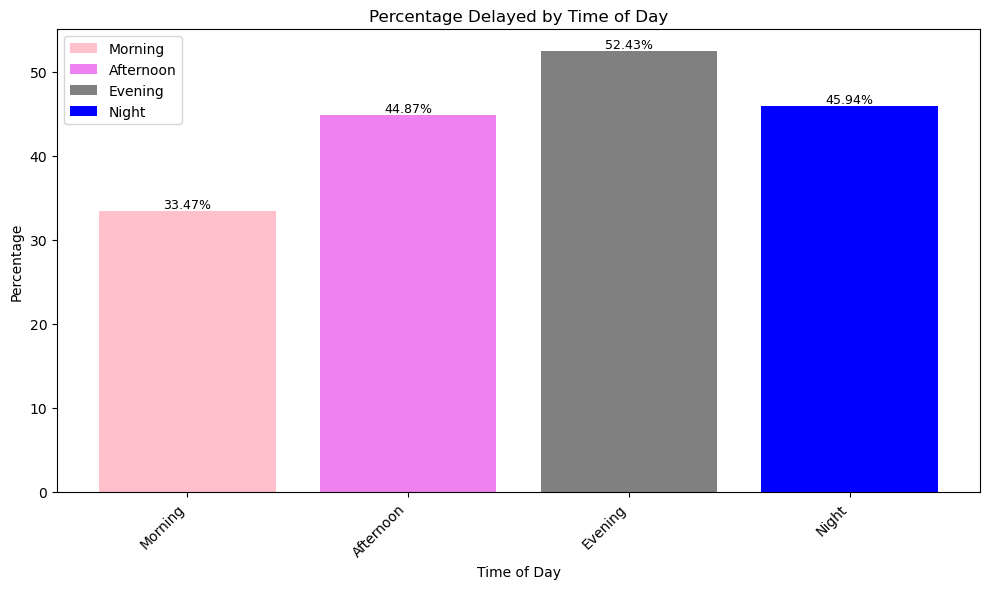

In [9]:
#Arrange time of day in order
DayTime_df['Time of Day'] = pd.Categorical(DayTime_df['Time of Day'], categories=['Morning', 'Afternoon', 'Evening', 'Night'], ordered=True)
DayTime_df.sort_values(by='Time of Day', inplace=True)

#Plot bar graph
plt.figure(figsize=(10, 6))
DayTimePercentage = plt.bar(DayTime_df['Time of Day'], DayTime_df['Percentage Delayed'], color=['pink', 'violet', 'grey', 'blue'])
plt.title('Percentage Delayed by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha='right')
for i, value in enumerate(DayTime_df['Percentage Delayed']):
    plt.text(i, value, f'{round(value, 2)}%', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.legend(DayTimePercentage, DayTime_df['Time of Day'], loc='upper left')

#Print resulting graph
plt.savefig('DayTimePercentage.png')
plt.show()


The bar graph above illustrates the percentage of delayed flights categorised by different times of the day.

We will now create a table summarising the average delay of flights by time of day.


In [10]:
#Compute the average delay in arrival
AvgDayTime_Arr = DayTime[['ArrDelay', 'arr_timebin']].groupby(['arr_timebin']).mean().reset_index(drop=False)
AvgDayTime_Arr.rename(columns={'arr_timebin': 'Time of Day', 'ArrDelay': 'Average Delay in Arrival'}, inplace=True)

#Compute the average delay in departure
AvgDayTime_Dep = DayTime[['DepDelay', 'dep_timebin']].groupby(['dep_timebin']).mean().reset_index(drop=False)
AvgDayTime_Dep.rename(columns={'dep_timebin': 'Time of Day', 'DepDelay': 'Average Delay in Departure'}, inplace=True)

#Merge and compute the total average delays
AvgDayTime_merged = pd.merge(AvgDayTime_Dep, AvgDayTime_Arr, how='left', left_on=['Time of Day'], right_on=['Time of Day'])
AvgDayTime_merged['Total Average Delay'] = (AvgDayTime_merged['Average Delay in Departure'] + AvgDayTime_merged['Average Delay in Arrival'])
AvgDayTime_merged = AvgDayTime_merged.sort_values(by='Total Average Delay', ascending=True)

#Print resulting table
AvgDayTime_merged_table = AvgDayTime_merged.style
AvgDayTime_merged_table


,Time of Day,Average Delay in Departure,Average Delay in Arrival,Total Average Delay
2,Morning,3.042348,0.304103,3.346451
0,Afternoon,8.242621,4.941710,13.184331
1,Evening,16.448041,11.991070,28.439111
3,Night,12.127133,38.562737,50.689869


The table above highlights that 'Night' exhibits the highest total average delay of 50.69 minutes, while 'Morning' records a significantly lower figure of only 3.35 minutes.

Interestingly, this finding diverges from the percentage of delayed flights, where 'Evening' experiences a total average delay of 28.44 minutes, positioning it just below 'Night', which has the highest total average delay of 50.69 minutes.

We will now plot a bar graph showing the average delays of flights by time of day.

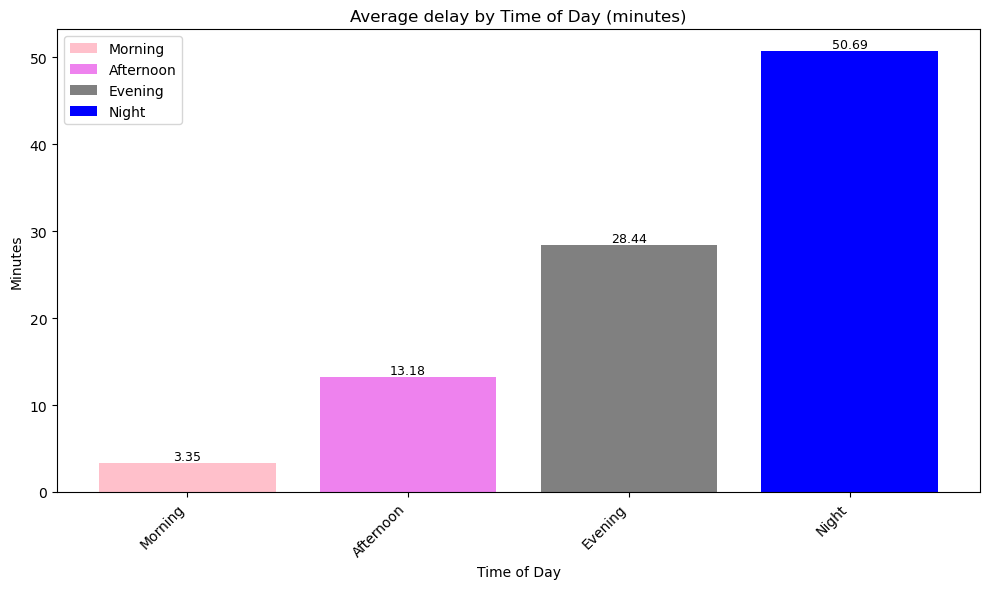

In [11]:
#Arrange time of day in order
AvgDayTime_merged['Time of Day'] = pd.Categorical(AvgDayTime_merged['Time of Day'], categories=['Morning', 'Afternoon', 'Evening', 'Night'], ordered=True)
AvgDayTime_merged.sort_values(by='Time of Day', inplace=True)

#Plot bar graph
plt.figure(figsize=(10, 6))
DayTimeAverage = plt.bar(AvgDayTime_merged['Time of Day'], AvgDayTime_merged['Total Average Delay'], color=['pink', 'violet', 'grey', 'blue'])
plt.title('Average delay by Time of Day (minutes)')
plt.xlabel('Time of Day')
plt.ylabel('Minutes')
plt.xticks(rotation=45, ha='right')
for i, value in enumerate(AvgDayTime_merged['Total Average Delay']):
    plt.text(i, value, f'{round(value, 2)}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.legend(DayTimeAverage, AvgDayTime_merged['Time of Day'], loc='upper left')

#Pritn resulting graph
plt.savefig('DayTimeAverage.png')
plt.show()


The bar graph above illustrates the total average delay categorised by different times of the day.

We will now plot a violin plot showing distribution of delays across years by time of day.

C:\Users\Owner\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


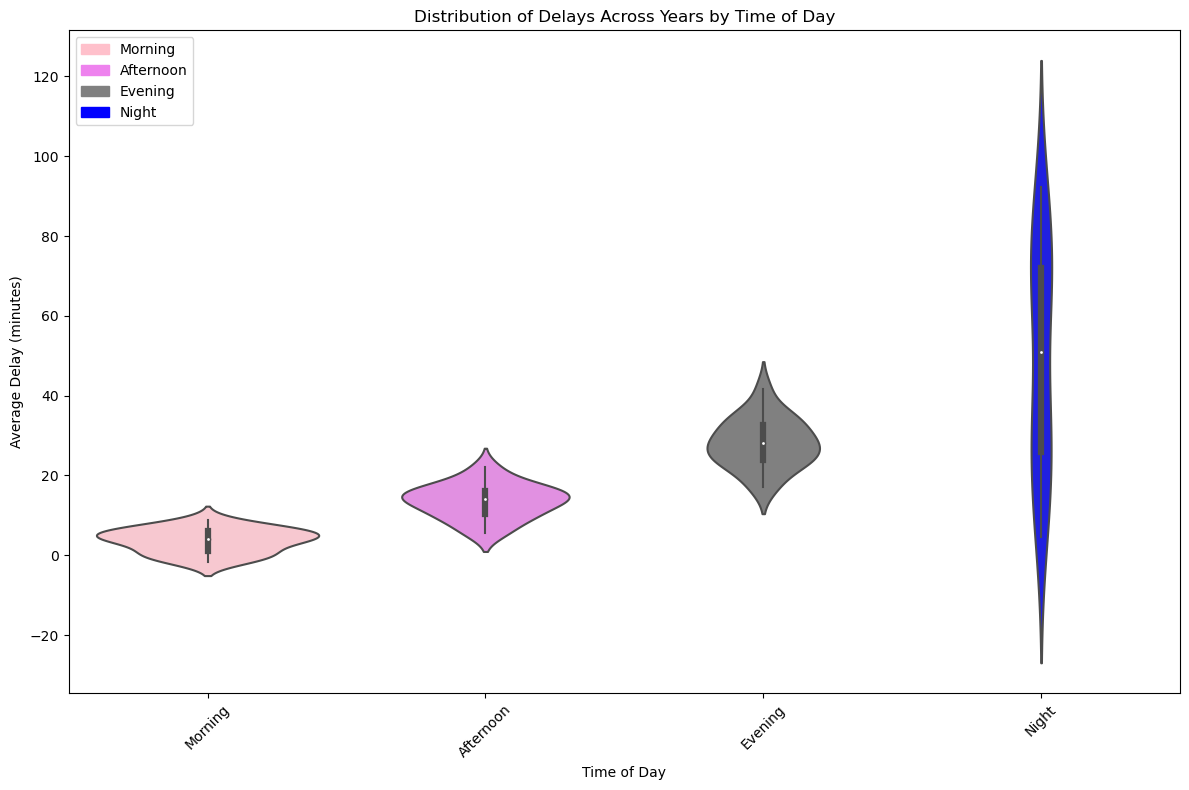

In [12]:
#Prepare departure delay data
DelaybyDayTime_Dep = planes.groupby(['Year', 'dep_timebin'])['Delays'].mean().reset_index()

#Prepare arrival delay data
DelaybyDayTime_Arr = planes.groupby(['Year', 'arr_timebin'])['Delays'].mean().reset_index()

#Merge departure and arrival delay data into one dataframe
DelaybyDayTime_Dep.rename(columns={'dep_timebin': 'timebin'}, inplace=True)
DelaybyDayTime_Arr.rename(columns={'arr_timebin': 'timebin'}, inplace=True)
DayTimeDelay = pd.concat([DelaybyDayTime_Dep, DelaybyDayTime_Arr])
DayTimeDelay = DayTimeDelay.dropna()

#Arrange time of day in order
TimeOrder = ['Morning', 'Afternoon', 'Evening', 'Night']
DayTimeDelay['timebin'] = pd.Categorical(DayTimeDelay['timebin'], categories=TimeOrder, ordered=True)

#Plot violin plot
plt.figure(figsize=(12, 8))
ViolinPlotDayTime = sns.violinplot(data=DayTimeDelay, x='timebin', y='Delays', inner='box', palette=['pink', 'violet', 'grey', 'blue'])
plt.title('Distribution of Delays Across Years by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Average Delay (minutes)')
plt.xticks(rotation=45)
plt.tight_layout()
ViolinPlotDayTime_colours = {'Morning': 'pink', 'Afternoon': 'violet', 'Evening': 'grey', 'Night': 'blue'}
ViolinPlotDayTime_labels = ['Morning', 'Afternoon', 'Evening', 'Night']
ViolinPlotDayTime_handles = [plt.Rectangle((0,0),1,1, color=color) for color in ViolinPlotDayTime_colours.values()]
plt.legend(ViolinPlotDayTime_handles, ViolinPlotDayTime_labels, loc='upper left')

#Print resulting violin plot
plt.savefig('DayTimeViolin.png')
plt.show()

The violin plot above illustrates delay distributions across different times of day. Each violin shape represents the density distribution of delays during specific periods.

'Morning' delays, depicted by a light pink violin, show a widening around 5 minutes of delay. 'Morning' has the lowest average delay among all times of day, peaking at approximately 15 minutes.

'Afternoon' delays, depicted by a violet violin, widen around 20 minutes, indicating a higher frequency of delays during this time. 'Afternoon' ranks as the second lowest in average delay among all times of day, peaking at approximately 30 minutes.

The grey 'Evening' violin plot is slightly thinner compared to the 'Morning' and 'Afternoon' violin plots. However, 'Evening' ranks as the second highest in average delay among all times of day, peaking at approximately 50 minutes.

The blue 'Night' violin plot is tall and thin, with a long tail extending up to 120 minutes, highlighting the presence of outliers with significant delays. 'Night' is proven to have the worst average delays out of all times of day.

Each violin plot features a box plot, with a white dot representing the median. Overall, the plot reveals variations in delay frequency and severity across different times of day, with 'Night' showing potential for extreme delays and 'Morning' exhibiting the least variation in delay times.

We will conclude our analysis on flight delays across different times of the day by visualising the average delay of flights spanning from 1995 to 2004 through a heatmap.

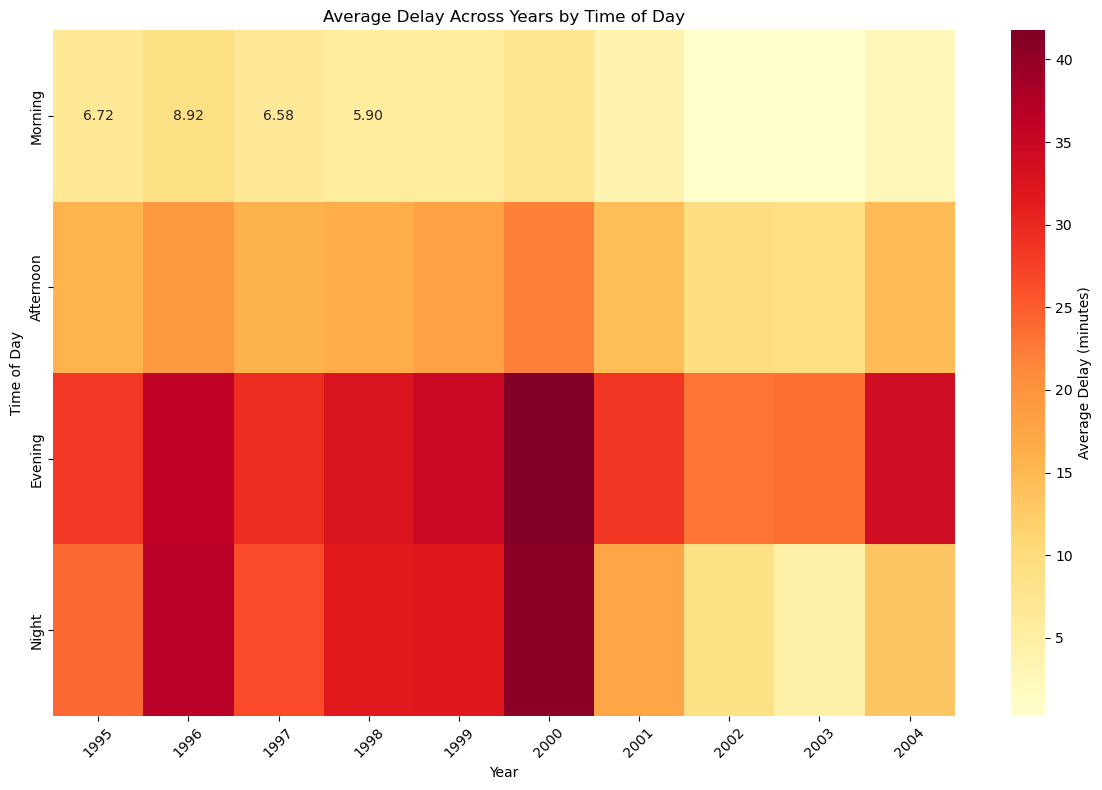

In [13]:
#Prepare departure delay data
DelaybyDayTime_Dep = planes.groupby(['Year', 'dep_timebin'])['Delays'].mean().reset_index()

#Prepare arrival delay data
DelaybyDayTime_Arr = planes.groupby(['Year', 'arr_timebin'])['Delays'].mean().reset_index()

#Merge departure and arrival delay data into one dataframe
DayTimeDelay2 = pd.concat([DelaybyDayTime_Dep, DelaybyDayTime_Arr])

#Create pivot table
DayTimeDelay_pivot = DayTimeDelay2.pivot_table(index='dep_timebin', columns='Year', values='Delays', aggfunc='mean')

#Arrange time of day in order
DayTimeDelay_pivot = DayTimeDelay_pivot.reindex(TimeOrder)

#Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(DayTimeDelay_pivot, cmap='YlOrRd', annot=True, fmt=".2f", cbar_kws={'label': 'Average Delay (minutes)'})
plt.title('Average Delay Across Years by Time of Day')
plt.xlabel('Year')
plt.ylabel('Time of Day')
plt.xticks(rotation=45)
plt.tight_layout()

#Print resulting heatmap
plt.savefig('HeatmapDayTime.png')
plt.show()

The heatmap above highlights significant trends: Evening periods consistently exhibit high average delays, with the highest delay recorded in 2000 at 41.76 minutes, while Morning periods consistently maintain low average delays, with the highest delay observed in 1996 at 8.92 minutes. 

In conclusion, our analysis employing bar graphs, violin plots, and heatmaps suggests that 'Morning' (6 a.m. to 12 p.m.) is the optimal time to minimise delays each year, followed by 'Afternoon' (12 p.m. to 6 p.m.). 

To mitigate delays, it is advisable to avoid scheduling flights during 'Evening' (6 p.m. to 12 a.m.) and 'Night' (12 a.m. to 6 a.m.) periods. These insights provide actionable recommendations for scheduling flights to optimise on-time performance and minimise delays.

#### a(ii). What are the best days of the week to minimise delays each year?

In [14]:
#Eliminate rows that have null values in the 'DayOfWeek' column
planes.dropna(subset=['DayOfWeek'], inplace=True)

#Define a function to map numerical values to their corresponding day of the week
def map_day(DayOfWeek):
    Day = {
        1:'Monday', 2:'Tuesday', 3:'Wednesday',
        4:'Thursday', 5:'Friday', 6:'Saturday',
        7:'Sunday'}
    return Day.get(DayOfWeek)

#Utilise the map_day function on 'DayOfWeek' column
planes['DayOfWeek'] = planes['DayOfWeek'].apply(map_day)

We will now create a table summarising the total number of flights, the percentage of flights, the count of delayed flights, and the percentage of delayed flights by day of week.

In [15]:
#Compute the percentage of flights for each day
DayWeekFlights = planes.groupby('DayOfWeek').size().reset_index(name='Flights')
TotalFlights = DayWeekFlights['Flights'].sum()
DayWeekFlights['Percentage of Flights'] = (DayWeekFlights['Flights'] / TotalFlights) * 100

#Total delays by day of week
DayWeekDelays = planes[(planes['DepDelay'] > 0) | (planes['ArrDelay'] > 0)].groupby('DayOfWeek').size().reset_index(name='Delays')

#Merge dataframes
DayWeekTotal = pd.merge(DayWeekFlights, DayWeekDelays, how='inner', on='DayOfWeek')

#Compute the percentage of flights delayed
DayWeekTotal['Percentage Delayed'] = (DayWeekTotal['Delays'] / DayWeekTotal['Flights']) * 100

#Rename column headers
DayWeekTotal.rename(columns={'DayOfWeek': 'Day of Week'}, inplace=True)
DayWeekTotal.sort_values(by='Percentage Delayed', inplace=True)

#Print resulting table
DayWeekTotal_table = DayWeekTotal.style
DayWeekTotal_table

,Day of Week,Flights,Percentage of Flights,Delays,Percentage Delayed
2,Saturday,7403277,12.865450,3786284,51.143352
5,Tuesday,8425678,14.642184,4334169,51.440003
6,Wednesday,8432651,14.654301,4532033,53.743870
1,Monday,8439830,14.666777,4544458,53.845374
3,Sunday,7994969,13.893696,4458324,55.764119
4,Thursday,8421930,14.635670,4882129,57.969242
0,Friday,8425527,14.641921,5051840,59.958742


The table above reveals that 'Friday' consistently experiences the highest percentage of delayed flights at 59.96%, contrasting with the lowest delay percentage of 51.14% on 'Saturday'. Notably, 'Friday' also boasts a substantial volume of flights, ranking fourth with a frequency of 14.64%, while 'Saturday' records the lowest flight frequency at 12.87%.

We will now plot a bar graph showing the percentage of delayed flights by day of week.

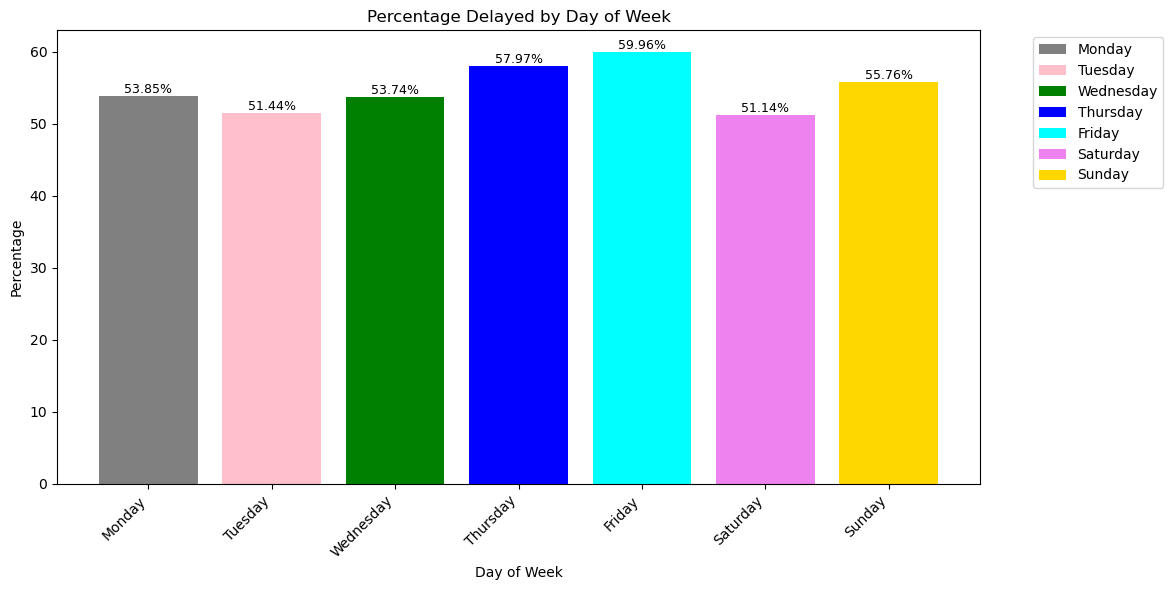

In [16]:
#Arrange day of week in order
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
DayWeekTotal['Day of Week'] = pd.Categorical(DayWeekTotal['Day of Week'], categories=day_order, ordered=True)
DayWeekTotal.sort_values(by='Day of Week', inplace=True)

#Plot bar graph 
plt.figure(figsize = (10, 6))
DayWeekPercentage = plt.bar(DayWeekTotal['Day of Week'], DayWeekTotal['Percentage Delayed'], color=['grey', 'pink', 'green', 'blue', 'cyan', 'violet', 'gold'])
plt.title('Percentage Delayed by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha='right')
for i, value in enumerate(DayWeekTotal['Percentage Delayed']):
    plt.text(i, value, f'{round(value, 2)}%', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.legend(DayWeekPercentage, DayWeekTotal['Day of Week'], loc='upper left', bbox_to_anchor=(1.05, 1))

#Print resulting graph
plt.savefig('DayWeekPercentage.png')
plt.show()


The bar graph above illustrates the percentage of delayed flights categorised by different days of the week.

We will now create a table summarising the average delay of flights by day of week.

In [17]:
#Compute average departure and arrival delays
AvgDayWeek = planes[['DayOfWeek', 'DepDelay', 'ArrDelay']].groupby(['DayOfWeek']).mean() 

#Compute total average delay
AvgDayWeek['Total Average Delay'] = AvgDayWeek['DepDelay'] + AvgDayWeek['ArrDelay']  

#Rename column headers
AvgDayWeek.reset_index(drop=False, inplace=True)
AvgDayWeek.rename(columns={'DayOfWeek': 'Day of Week', 'DepDelay': 'Average Departure Delay', 'ArrDelay': 'Average Arrival Delay'},
                     inplace=True)  
AvgDayWeek = AvgDayWeek.sort_values(by='Total Average Delay', ascending=True)  

#Print resulting table
AvgDayWeek_table = AvgDayWeek.style
AvgDayWeek_table

,Day of Week,Average Departure Delay,Average Arrival Delay,Total Average Delay
2,Saturday,7.013565,3.920646,10.934212
5,Tuesday,6.724647,5.593879,12.318526
6,Wednesday,7.527243,6.744079,14.271322
1,Monday,7.889729,6.494305,14.384034
3,Sunday,8.681325,6.560420,15.241744
4,Thursday,9.271596,8.697351,17.968947
0,Friday,10.430639,9.637633,20.068273


The data underscores 'Friday' as the most delay-prone day of the week, corroborated by the total average delay. 'Friday' ranks lowest, exhibiting the highest total average delay of 20.07 minutes, whereas 'Saturday' claims the top spot with the least total average delay of 10.93 minutes.

We will now plot a bar graph showing the average delay of flights by day of week.

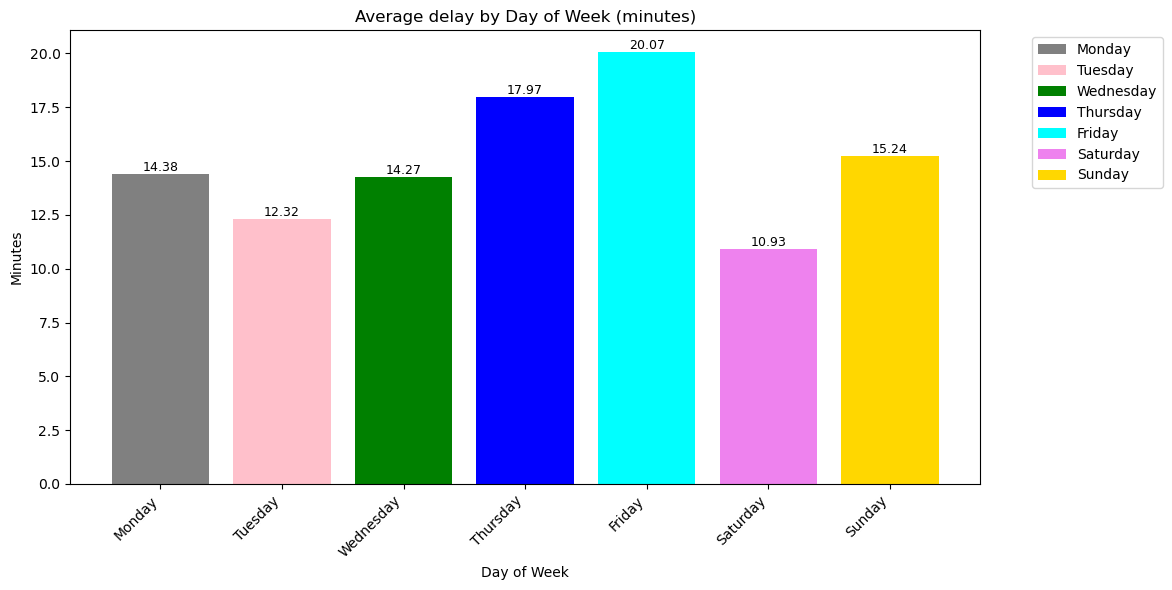

In [18]:
#Arrange day of week in order
AvgDayWeek['Day of Week'] = pd.Categorical(AvgDayWeek['Day of Week'], categories=day_order, ordered=True)
AvgDayWeek.sort_values(by='Day of Week', inplace=True)

#Plot bar graph
plt.figure(figsize = (10, 6))
DayWeekAverage = plt.bar(AvgDayWeek['Day of Week'], AvgDayWeek['Total Average Delay'], color=['grey', 'pink', 'green', 'blue', 'cyan', 'violet', 'gold'])
plt.title('Average delay by Day of Week (minutes)')
plt.xlabel('Day of Week')
plt.ylabel('Minutes')
plt.xticks(rotation=45, ha='right')
for i, value in enumerate(AvgDayWeek['Total Average Delay']):
    plt.text(i, value, f'{round(value, 2)}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.legend(DayWeekAverage, AvgDayWeek['Day of Week'], loc='upper left', bbox_to_anchor=(1.05, 1))

#Print resulting graph
plt.savefig('DayWeekAverage.png')
plt.show()


The bar graph above illustrates the total average delay categorised by different days of the week.

We will now plot a violin plot showing distribution of delays across years by day of week.

C:\Users\Owner\AppData\Local\Temp\ipykernel_14940\334277619.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  DelaybyDayWeek = planes.groupby(['Year', 'DayOfWeek'])['Delays'].mean().reset_index()


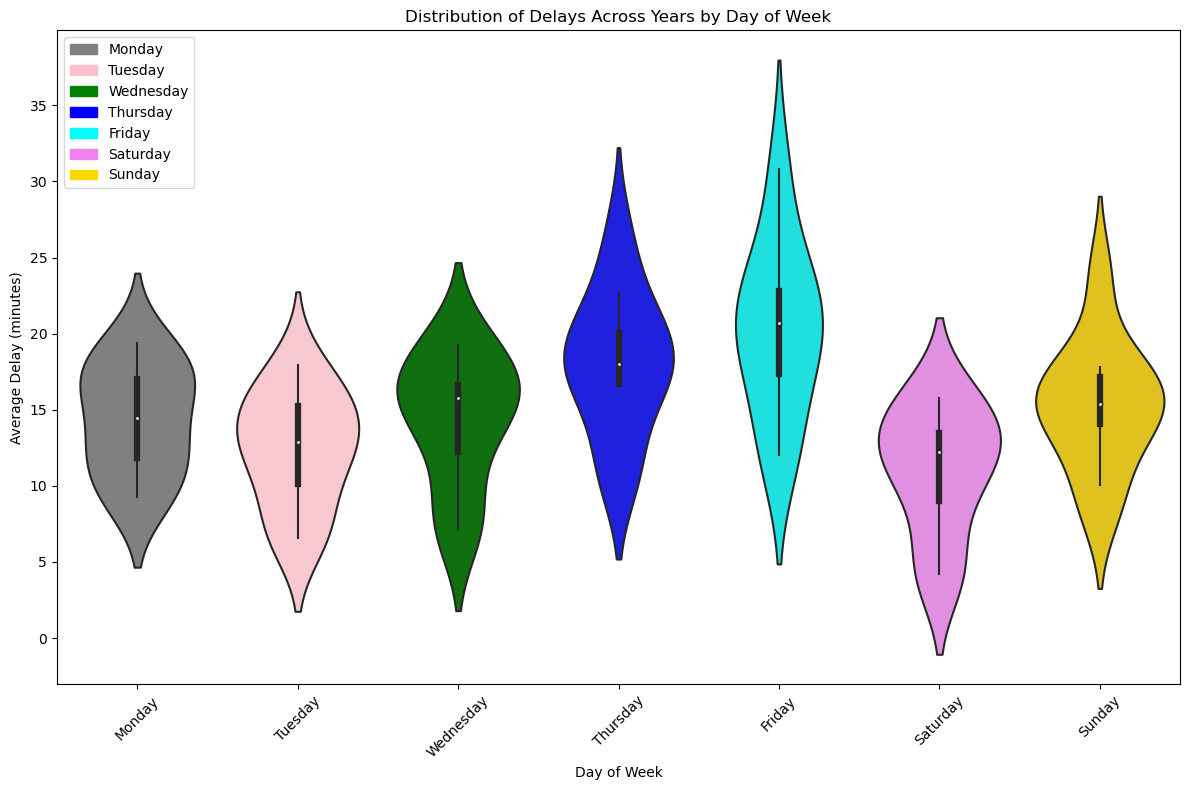

In [19]:
#Convert 'DayOfWeek' to categorical data type with specified order
planes['DayOfWeek'] = pd.Categorical(planes['DayOfWeek'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)

#Compute the average delay for each year and day of the week 
DelaybyDayWeek = planes.groupby(['Year', 'DayOfWeek'])['Delays'].mean().reset_index()

#Create a pivot table for the violin plot
pivot_DelaybyDayWeek = DelaybyDayWeek.pivot(index='Year', columns='DayOfWeek', values='Delays')

#Plot the violin plot
plt.figure(figsize=(12, 8))
ViolinPlotDayWeek = sns.violinplot(data=pivot_DelaybyDayWeek, inner='box', palette=['grey', 'pink', 'green', 'blue', 'cyan', 'violet', 'gold'])
plt.title('Distribution of Delays Across Years by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Delay (minutes)')
plt.xticks(rotation=45)
plt.tight_layout()
ViolinPlotDayWeek_colours = {'Monday': 'grey', 'Tuesday': 'pink', 'Wednesday': 'green', 'Thursday': 'blue', 'Friday': 'cyan', 'Saturday': 'violet', 'Sunday': 'gold'}
ViolinPlotDayWeek_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ViolinPlotDayWeek_handles = [plt.Rectangle((0,0),1,1, color=color) for color in ViolinPlotDayWeek_colours.values()]
plt.legend(ViolinPlotDayWeek_handles, ViolinPlotDayWeek_labels, loc='upper left')

#Print the violin plot
plt.savefig('DayWeekViolin.png')
plt.show()

The violin plot above illustrates delay distributions across different day of the week. Each violin shape represents the density distribution of delays during specific periods.

'Monday', 'Tuesday', and 'Wednesday' violins have a similar plot and an approximately similar highest average delay of between 23 to 25 minutes.

The most notable would be the cyan 'Friday' violin plot. It has the thinnest and tallest plot, suggesting a presence of outliers with significant delays, with the highest average delay of approximately 37 minutes.

Conversely, the violet 'Saturday' violin plot has the lowest average delay of approximately 20 minutes, widening around 10 to 15 minutes.

Each violin plot features a box plot, with a white dot representing the median. Overall, the plot reveals variations in delay frequency and severity across different times of day, with 'Friday' showing potential for extreme delays and 'Saturday' exhibiting the least variation in delay times.

We will conclude our analysis on flight delays across different days of the week by visualising the average delay of flights spanning from 1995 to 2004 through a heatmap.

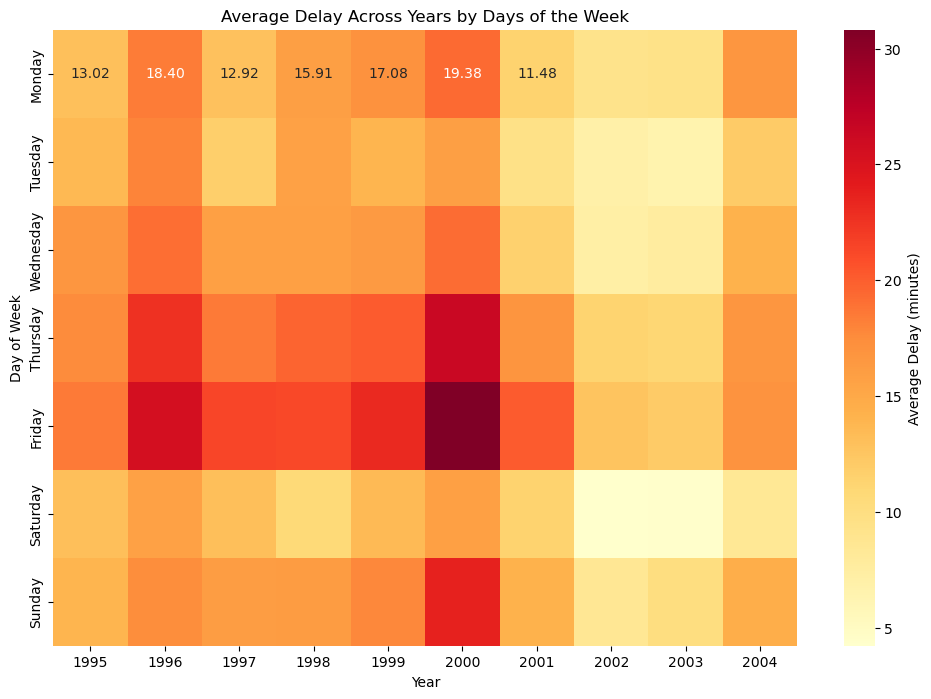

In [20]:
#Create a pivot table for the heatmap
pivot_DelaybyDayWeek2 = DelaybyDayWeek.pivot(index='DayOfWeek', columns='Year', values='Delays')

#Arrange days of the week in order
pivot_DelaybyDayWeek2 = pivot_DelaybyDayWeek2.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

#Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_DelaybyDayWeek2, cmap='YlOrRd', annot=True, fmt=".2f", cbar_kws={'label': 'Average Delay (minutes)'})
plt.title('Average Delay Across Years by Days of the Week')
plt.xlabel('Year')
plt.ylabel('Day of Week')

#Print the heatmap
plt.savefig('HeatmapDayWeek.png')
plt.show()

The heatmap above illustrates the average delay across years by days of the week. In 2000, 'Friday' experienced the most significant delay, reaching an average of 30.81 minutes.

Conversely, lighter colours indicate lower average delays, notably on 'Saturday', with its lowest average delays observed in 2002 and 2003 of 4.22 minutes and 4.34 minutes respectively.

In conclusion, our analysis employing bar graphs, violin plots, and heatmaps suggests that 'Saturday' is the most optimal day to minimise delays each year.

To mitigate delays, it is advisable to avoid scheduling many flights on 'Friday'. These insights provide actionable recommendations for scheduling flights to optimise on-time performance and minimise delays.

### b. Evaluate whether older planes suffer more delays on year-to-year basis

In [21]:
#Subset 'plane_data' dataframe to include only needed columns
planedata_subset = plane_data[['tailnum', 'year']].rename(columns={'tailnum': 'TailNum', 'year': 'PlaneYear'})

#Merge 'planes' dataframe with 'plane_data' dataframe using Tail Number
airplanes = planes.merge(planedata_subset, how='left', left_on='TailNum', right_on='TailNum')

#Exclude rows where year information is missing
airplanes = airplanes[~airplanes['PlaneYear'].isna()]

#Rename the 'year' column from 'plane_data' dataframe to 'PlaneYear'
airplanes.rename(columns={'year': 'PlaneYear'}, inplace=True)

#Print the resulting dataframe
airplanes #Ensure that all values are valid

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Delays,arr_timebin,dep_timebin,PlaneYear
54,1995,1,2,Monday,1148.0,1145,1428.0,1435,UA,1845,...,0,NaN,NaN,NaN,NaN,NaN,-4.0,Afternoon,Morning,1992.0
55,1995,1,3,Tuesday,1209.0,1145,1450.0,1435,UA,1845,...,0,NaN,NaN,NaN,NaN,NaN,39.0,Afternoon,Afternoon,1991.0
59,1995,1,7,Saturday,1200.0,1150,1447.0,1440,UA,1845,...,0,NaN,NaN,NaN,NaN,NaN,17.0,Afternoon,Morning,1992.0
60,1995,1,8,Sunday,1151.0,1150,1435.0,1440,UA,1845,...,0,NaN,NaN,NaN,NaN,NaN,-4.0,Afternoon,Morning,1987.0
61,1995,1,9,Monday,1154.0,1150,1433.0,1440,UA,1845,...,0,NaN,NaN,NaN,NaN,NaN,-3.0,Afternoon,Morning,1991.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57543857,2004,12,16,Thursday,1645.0,1639,1715.0,1716,DL,1138,...,0,0.0,0.0,0.0,0.0,0.0,5.0,Afternoon,Afternoon,1991.0
57543858,2004,12,16,Thursday,726.0,720,1238.0,1239,DL,1139,...,0,0.0,0.0,0.0,0.0,0.0,5.0,Afternoon,Morning,1993.0
57543859,2004,12,16,Thursday,1336.0,1330,1507.0,1504,DL,1139,...,0,0.0,0.0,0.0,0.0,0.0,9.0,Afternoon,Afternoon,1993.0
57543860,2004,12,16,Thursday,538.0,540,720.0,723,DL,1140,...,0,0.0,0.0,0.0,0.0,0.0,-5.0,Morning,Night,1991.0


An airplanes is classified as old once it has surpassed 21 years since its initial construction. (Paramount Business Jets, n.d.)

We will now classify airplanes as either "old" or "new" depending on their manufacturing year

In [22]:
#Calculate the age of each plane using the year data from the CSV files
airplanes['PlaneAge'] = airplanes['Year'] - airplanes['PlaneYear']

#Define bins and labels for old and new planes
bins = [0, 21, float('inf')]  #21 years is the threshold for old planes
labels = ['New', 'Old']

#Categorise planes based on age
airplanes['PlaneAgeCategory'] = pd.cut(airplanes['PlaneAge'], bins=bins, labels=labels)

#Introduce a boolean column for flight delays, assigning 1 to denote delayed flights and 0 for punctual ones, determined by departure and arrival delay assessments.
airplanes['Delayed_Boolean'] = ((airplanes['DepDelay'] > 0) | (airplanes['ArrDelay'] > 0)).astype(int)

#Select relevant columns
airplanes_bin = airplanes[['PlaneAge', 'PlaneYear', 'Delayed_Boolean', 'ArrDelay', 'DepDelay', 'PlaneAgeCategory']]
airplanes_bin

,PlaneAge,PlaneYear,Delayed_Boolean,ArrDelay,DepDelay,PlaneAgeCategory
54,3.0,1992.0,1,-7.0,3.0,New
55,4.0,1991.0,1,15.0,24.0,New
59,3.0,1992.0,1,7.0,10.0,New
60,8.0,1987.0,1,-5.0,1.0,New
61,4.0,1991.0,1,-7.0,4.0,New
...,...,...,...,...,...,...
57543857,13.0,1991.0,1,-1.0,6.0,New
57543858,11.0,1993.0,1,-1.0,6.0,New
57543859,11.0,1993.0,1,3.0,6.0,New
57543860,13.0,1991.0,0,-3.0,-2.0,New


In [23]:
# Filter out rows with invalid PlaneYear values and set the maximum PlaneYear to 2004, since the dataset only covers the years from 1995 to 2004.
airplanes_bin = airplanes[(airplanes['PlaneYear'] > 1900) & (airplanes['PlaneYear'] <= 2004)]

#Print oldest and newest plane manufacture year
print("Oldest:", int(airplanes_bin['PlaneYear'].min()))
print("Newest:", int(airplanes_bin['PlaneYear'].max()))

# Print the oldest and newest plane ages (PlaneAge)
print("Oldest Plane Age:", int(airplanes_bin['PlaneAge'].max()))
print("Newest Plane Age:", int(airplanes_bin['PlaneAge'].min()))

Oldest: 1956
Newest: 2004
Oldest Plane Age: 48
Newest Plane Age: -6


Considering that a negative Plane Age lacks validity, our approach will set the newest plane age to zero.

In [24]:
#Replace negative PlaneAge values with zero
airplanes_bin.loc[:, 'PlaneAge'] = airplanes_bin['PlaneAge'].clip(lower=0)

#Print the oldest and newest plane ages (PlaneAge)
print("Oldest Plane Age:", int(airplanes_bin['PlaneAge'].max()))
print("Newest Plane Age:", int(airplanes_bin['PlaneAge'].min()))

Oldest Plane Age: 48
Newest Plane Age: 0


The aircraft manufacturing dates range from 1956, the earliest, to 2004 (since the imported dataset only covers the years from 1995 to 2004), the most recent. The oldest plane in operation is 48 years old, whereas the newest planes are freshly flown, at 0 years old.

In [25]:
#Number of new and old planes
airplanes_bin.PlaneAgeCategory.value_counts()

PlaneAgeCategory
New    19366539
Old     1211233
Name: count, dtype: int64

We will now create a table summarising the total number of flights, the percentage of flights, the count of delayed flights, and the percentage of delayed flights by 'PlaneAgeCategory' by day of week.

In [26]:
#Compute count of flights per age category
Percentage_airplanes = airplanes_bin.groupby('PlaneAgeCategory').size().reset_index(name='Flights')  

#Compute sum of the delayed flights and total delays per age category.
Total_airplanes = airplanes_bin.groupby('PlaneAgeCategory')['Delayed_Boolean'].sum().reset_index(name='Total Delayed')

#Merge dataframes
PercentageTotal_airplanes = pd.merge(Percentage_airplanes, Total_airplanes, how='inner', on='PlaneAgeCategory')

#Compute the percentage of total flights for each age category.
total_flights = PercentageTotal_airplanes['Flights'].sum()
PercentageTotal_airplanes['Percentage of Flights'] = (PercentageTotal_airplanes['Flights'] / total_flights) * 100

#Compute the percentage of delayed flights for each age category.
PercentageTotal_airplanes['Percentage Delayed'] = (PercentageTotal_airplanes['Total Delayed'] / PercentageTotal_airplanes['Flights']) * 100
                                          
#Rename coloumn headers
PercentageTotal_airplanes.rename(columns={'PlaneAgeCategory': 'Plane Age Category'}, inplace=True)
PercentageTotal_airplanes = PercentageTotal_airplanes.sort_values(by='Percentage Delayed', ascending=True)

#Print the resulting table
PercentageTotal_airplanes_table = PercentageTotal_airplanes[['Plane Age Category', 'Flights', 'Percentage of Flights', 'Total Delayed', 'Percentage Delayed']].style
PercentageTotal_airplanes_table

C:\Users\Owner\AppData\Local\Temp\ipykernel_14940\2425251640.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Percentage_airplanes = airplanes_bin.groupby('PlaneAgeCategory').size().reset_index(name='Flights')
C:\Users\Owner\AppData\Local\Temp\ipykernel_14940\2425251640.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Total_airplanes = airplanes_bin.groupby('PlaneAgeCategory')['Delayed_Boolean'].sum().reset_index(name='Total Delayed')


,Plane Age Category,Flights,Percentage of Flights,Total Delayed,Percentage Delayed
1,Old,1211233,5.886123,577685,47.693961
0,New,19366539,94.113877,11070781,57.164478


The table above highlights a significant trend: New planes (aged 0 to 21 years) contribute to a higher proportion of delayed flights, representing 57.16% of delays among all New planes, compared to Old planes (aged 21 years and above), which contribute to 47.69% of delays among all Old planes.

However, it's essential to interpret this observation considering the discrepancy in the number of flights operated by each category. New planes, totaling 19,366,539 flights, represent 94.11% of all flights, while Old planes, totaling 1,211,233 flights, represent only 5.89% of all flights.

Despite this discrepancy, the total number of delays varies significantly between the two categories. New planes experienced a total of 11,070,781 delays, while Old planes had a total of 577,685 delays.

We will now plot a bar graph showing the percentage of delayed flights for old and new planes.

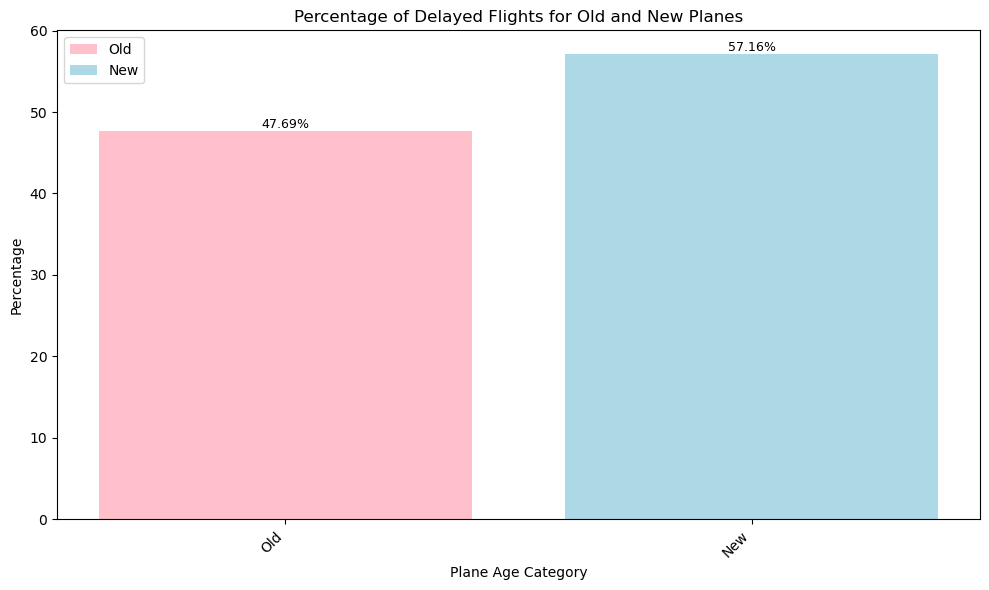

In [27]:
#Convert Plane Age to categorical type with correct order
PercentageTotal_airplanes['Plane Age Category'] = pd.Categorical(PercentageTotal_airplanes['Plane Age Category'], categories=['Old', 'New'], ordered=True)
PercentageTotal_airplanes = PercentageTotal_airplanes.sort_values(by='Plane Age Category') 

#Plot bar graph
plt.figure(figsize=(10, 6))
DayWeekAverage = plt.bar(PercentageTotal_airplanes['Plane Age Category'], PercentageTotal_airplanes['Percentage Delayed'], color=['pink', 'lightblue'])
plt.title('Percentage of Delayed Flights for Old and New Planes')
plt.xlabel('Plane Age Category')
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha='right')
for i, value in enumerate(PercentageTotal_airplanes['Percentage Delayed']):
    plt.text(i, value, f'{round(value, 2)}%', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.legend(DayWeekAverage, PercentageTotal_airplanes['Plane Age Category'], loc='upper left')
          
#Print resulting graph
plt.savefig('PercentageAirplanes.png')
plt.show()

The bar graph above illustrates the percentage of delayed flights categorised by plane age category (New/Old).

We will now create a table summarising the average delay of flights by 'Plane Age Category'.

In [28]:
#Compute average departure and arrival delays
Avg_airplanes = airplanes_bin.groupby('PlaneAgeCategory')[['DepDelay', 'ArrDelay']].mean().reset_index()

#Compute total average delay
Avg_airplanes['Total Average Delay'] = Avg_airplanes['DepDelay'] + Avg_airplanes['ArrDelay'] 

#Rename column headers
Avg_airplanes.rename(columns={'ArrDelay': 'Average Arrival Delay',
                               'DepDelay': 'Average Departure Delay', 'PlaneAgeCategory': 'Plane Age Category'}, inplace=True)
Avg_airplanes = Avg_airplanes.sort_values(by='Total Average Delay', ascending=True)

#Print resulting table
Avg_airplanes_table = Avg_airplanes[['Plane Age Category', 'Average Departure Delay', 'Average Arrival Delay', 'Total Average Delay']].style
Avg_airplanes_table

C:\Users\Owner\AppData\Local\Temp\ipykernel_14940\1866304218.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Avg_airplanes = airplanes_bin.groupby('PlaneAgeCategory')[['DepDelay', 'ArrDelay']].mean().reset_index()


,Plane Age Category,Average Departure Delay,Average Arrival Delay,Total Average Delay
1,Old,5.586006,4.898296,10.484302
0,New,7.794338,6.749482,14.543820


The table above reveals that New planes (aged 0 to 21 years) exhibit a slightly higher total average delay of 14.54 minutes compared to Old planes (aged 21 years and above), which have an average delay of 10.48 minutes.

Furthermore, New planes demonstrate slightly higher average departure and arrival delays compared to Old planes. Along with the percentage of delayed flights for both Old and New planes, it appears that Old planes do not significantly contribute to flight delays.

We will now plot a bar graph showing the average delay of flights by 'Plane Age Category'.

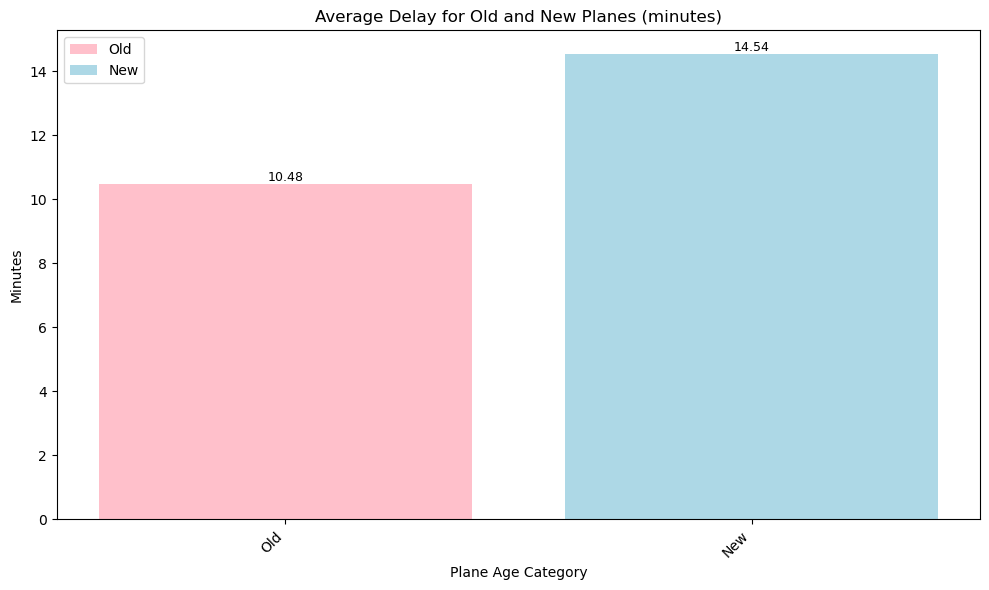

In [29]:
#Convert Plane Age to categorical type with correct order
Avg_airplanes['Plane Age Category'] = pd.Categorical(Avg_airplanes['Plane Age Category'], categories=['Old', 'New'], ordered=True)
Avg_airplanes = Avg_airplanes.sort_values(by='Plane Age Category') 

#Plot bar graph
plt.figure(figsize=(10, 6))
MeanAirplanes = plt.bar(Avg_airplanes['Plane Age Category'], Avg_airplanes['Total Average Delay'], color=['pink', 'lightblue'])
plt.title('Average Delay for Old and New Planes (minutes)')
plt.xlabel('Plane Age Category')
plt.ylabel('Minutes')
plt.xticks(rotation=45, ha='right')
for i, value in enumerate(Avg_airplanes['Total Average Delay']):
    plt.text(i, value, f'{value:.2f}', ha='center', va='bottom', fontsize=9) 
plt.tight_layout()
plt.legend(MeanAirplanes, Avg_airplanes['Plane Age Category'], loc='upper left')

#Print resulting graph
plt.savefig('MeanAirplanes.png')
plt.show()

The bar graph above illustrates the average delay categorised by plane age (New/Old).

We will now create a table summarising the total number of delays by 'Plane Age Category' per year.

In [30]:
#Filter the data to include only years from 1995 to 2004
airplanes_filtered = airplanes[(airplanes['Year'] >= 1995) & (airplanes['Year'] <= 2004)]

#Compute the total number of delays for each year and plane age category
DelaysPerYear = airplanes_filtered.groupby(['Year', 'PlaneAgeCategory'])['Delayed_Boolean'].sum().reset_index()

#Rename column header
DelaysPerYear = DelaysPerYear.rename(columns={'Delayed_Boolean': 'Total Delays'})

#Print resulting table
DelaysPerYear_table = DelaysPerYear.style
DelaysPerYear_table

C:\Users\Owner\AppData\Local\Temp\ipykernel_14940\3544729527.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  DelaysPerYear = airplanes_filtered.groupby(['Year', 'PlaneAgeCategory'])['Delayed_Boolean'].sum().reset_index()


,Year,PlaneAgeCategory,Total Delays
0,1995,New,1035739
1,1995,Old,43173
2,1996,New,1085180
3,1996,Old,54254
4,1997,New,1063296
5,1997,Old,67218
6,1998,New,1019832
7,1998,Old,63264
8,1999,New,1086825
9,1999,Old,61653


We will conclude our analysis on flight delays by Plane Age Category, covering the period from 1995 to 2004, with a line graph  showing Plane Age Category delays across the years.

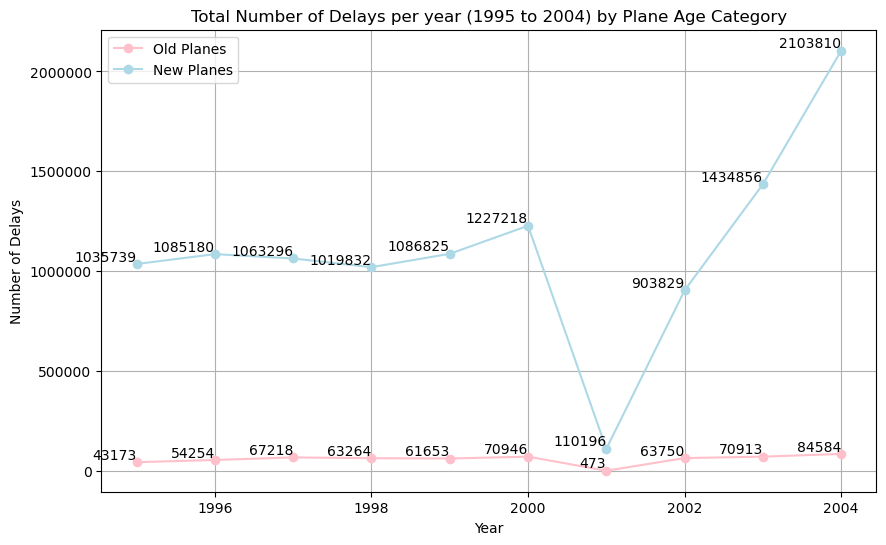

In [31]:
plt.figure(figsize=(10, 6))

#Plot for Old planes
plt.plot(DelaysPerYear[DelaysPerYear['PlaneAgeCategory'] == 'Old']['Year'], 
         DelaysPerYear[DelaysPerYear['PlaneAgeCategory'] == 'Old']['Total Delays'], 
         marker='o', linestyle='-', label='Old Planes', color='pink')

#Plot for New planes
plt.plot(DelaysPerYear[DelaysPerYear['PlaneAgeCategory'] == 'New']['Year'], 
         DelaysPerYear[DelaysPerYear['PlaneAgeCategory'] == 'New']['Total Delays'], 
         marker='o', linestyle='-', label='New Planes', color='lightblue')

#Plot line graph
plt.xlabel('Year')
plt.ylabel('Number of Delays')
plt.title('Total Number of Delays per year (1995 to 2004) by Plane Age Category')
plt.legend()
plt.grid(True)
plt.ticklabel_format(style='plain')

#Annotate each point with its corresponding value
for index, row in DelaysPerYear.iterrows():
    plt.text(row['Year'], row['Total Delays'], f'{row["Total Delays"]}', ha='right', va='bottom')

#Print resulting graph
plt.savefig('TotalDelay.png')
plt.show()


Based on the analysis comparing flight delays between Old planes (aged 21 years and above) and New planes (aged 0 to 21 years), it can be inferred that older planes do not necessarily suffer more delays on a year-to-year basis.

The line graph illustrates that New planes generally experience more delays overall. In 2004, New planes recorded the highest number of delays, exceeding two million, while in 2001, they had the lowest, approximately 110,000 delays. In contrast, Old planes exhibited their largest number of delays in 2000, with 70,946 flights, and the lowest in 2004, with 473 flights

Despite operating fewer flights overall (1,211,233 flights compared to 19,366,539 flights for New planes), Old planes showed a percentage of delayed flights close to 50%, only about 10% less than New planes. This suggests that while new planes experience more delays in absolute numbers due to their higher flight volume, the percentage of delayed flights remains comparable between the two categories.

Therefore, while it may be tempting to conclude that older planes suffer more delays, a deeper examination reveals that this assertion may not hold true on a year-to-year basis. Nonetheless, older planes still contribute significantly to the total number of delayed flights within their category (47.69% of delayed flights within the old planes category).


### c. For each year, fit a logistic regression model for the probability of diverted US flights using as many features as possible from attributes of the departure date, the scheduled departure and arrival times, the coordinates and distance between departure and planned arrival airports, and the carrier. Visualie the coefficients across years.

In [32]:
#Display columns headers of 'planes' dataframe
planes.columns

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime',
       'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay',
       'Delays', 'arr_timebin', 'dep_timebin'],
      dtype='object')

In [9]:
#Select features from the 'planes' dataframe to be used in the analysis
PlaneFeatures = ['Month', 'DayofMonth', 'DepTime', 'UniqueCarrier', 'DepDelay'
                 , 'Distance']

X = planes[PlaneFeatures].copy()
y = planes['Diverted']

In [10]:
#Numerical features are 'DepTime', 'ArrTime', 'ArrDelay', 'DepDelay', and 'Distance'
PlaneFeatures_numerical = ['DepTime', 'DepDelay', 'Distance']

#Apply Imputation on missing values and scaling
PlaneFeatures_numericaltransformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

#Categorical features are 'Month', 'DayofMonth', and 'UniqueCarrier'
PlaneFeatures_categorical = ['Month', 'DayofMonth', 'UniqueCarrier']

#Apply Imputation and create dummy variables
PlaneFeatures_categoricaltransformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [11]:
#Merge both numerical and categorical features
PlaneFeatures_transformer = ColumnTransformer(
    transformers=[
        ('numerical', PlaneFeatures_numericaltransformer, PlaneFeatures_numerical),
        ('categorical', PlaneFeatures_categoricaltransformer, PlaneFeatures_categorical)])

In [36]:
#Split data into trains and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.5,
                                                    random_state=1)

In [37]:
#Logistic regression learner
PlaneFeatures_pipeLR = Pipeline(steps=[
    ('preprocessor', PlaneFeatures_transformer),
    ('classifier', LogisticRegression(max_iter=10000))
])

#Fit logistic regression model
PlaneFeatures_pipeLR.fit(X_train, y_train)



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['DepTime', 'DepDelay',
                                                   'Distance']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Month', 'DayofMonth',
                                                   'UniqueCarrier'])])),
                ('classifier', LogisticRegression(max_iter=10000))])

In [38]:
#Gradient Boosting Learner 
PlaneFeatures_pipegdb = Pipeline(steps=[
    ('preprocessor', PlaneFeatures_transformer),
    ('classifier', GradientBoostingClassifier(random_state=2, n_estimators=25, max_depth=1))  # Adjust parameters as needed
])

#Fit Gradient Boosting model
PlaneFeatures_pipegdb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['DepTime', 'DepDelay',
                                                   'Distance']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Month', 'DayofMonth',
                                                   'UniqueCarrier'])])),
                ('classifier',
                 GradientBoostingClassifier(max_depth=1, n_estimators=25,
                                            random_state=2))])

Extend the analysis by incorporating results from other classification methods.

In [39]:
#Penalised Logistic Regression
PlaneFeatures_pipeplr = Pipeline(steps=[
    ('preprocessor', PlaneFeatures_transformer),
    ('classifier', LogisticRegression(penalty='l1', max_iter=10000, tol=0.01, solver='saga'))])

#Fit Penalised Logistic Regression model
PlaneFeatures_pipeplr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['DepTime', 'DepDelay',
                                                   'Distance']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Month', 'DayofMonth',
                                                   'UniqueCarrier'])])),
                ('classifier',
                 LogisticRegression(max_iter=10000, penalty='l1', solver='saga',
                                    tol=0.01))])

In [40]:
#Classification Tree
PlaneFeatures_pipetree = Pipeline(steps=[
    ('preprocessor', PlaneFeatures_transformer),
    ('classifier', DecisionTreeClassifier(random_state=0))])

#Fit Classification Tree model
PlaneFeatures_pipetree.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['DepTime', 'DepDelay',
                                                   'Distance']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Month', 'DayofMonth',
                                                   'UniqueCarrier'])])),
                ('classifier', DecisionTreeClassifier(random_state=0))])

In [41]:
#Predict probabilities for logistic regression, gradient boosting, penalised logistic regression, and classification tree classifiers
y_pred_lr = PlaneFeatures_pipeLR.predict_proba(X_test)[:, 1]
y_pred_gb = PlaneFeatures_pipegdb.predict_proba(X_test)[:, 1]
y_pred_plr = PlaneFeatures_pipeplr.predict_proba(X_test)[:, 1]
y_pred_tree = PlaneFeatures_pipetree.predict_proba(X_test)[:, 1]


In [42]:
#Compute ROC AUC scores
AUC_LR = roc_auc_score(y_test, y_pred_lr)
AUC_GBM = roc_auc_score(y_test, y_pred_gb)
AUC_PLR = roc_auc_score(y_test, y_pred_plr)
AUC_Tree = roc_auc_score(y_test, y_pred_tree)

print("Logistic Regression AUC:", AUC_LR)
print("Gradient Boosting AUC:", AUC_GBM)
print("Penalised Logistic Regression AUC:", AUC_PLR)
print("Classication Tree AUC:", AUC_Tree)

Logistic Regression AUC: 0.6743773989452223
Gradient Boosting AUC: 0.6868104738580717
Penalised Logistic Regression AUC: 0.6737491982081115
Classication Tree AUC: 0.5092487493455129


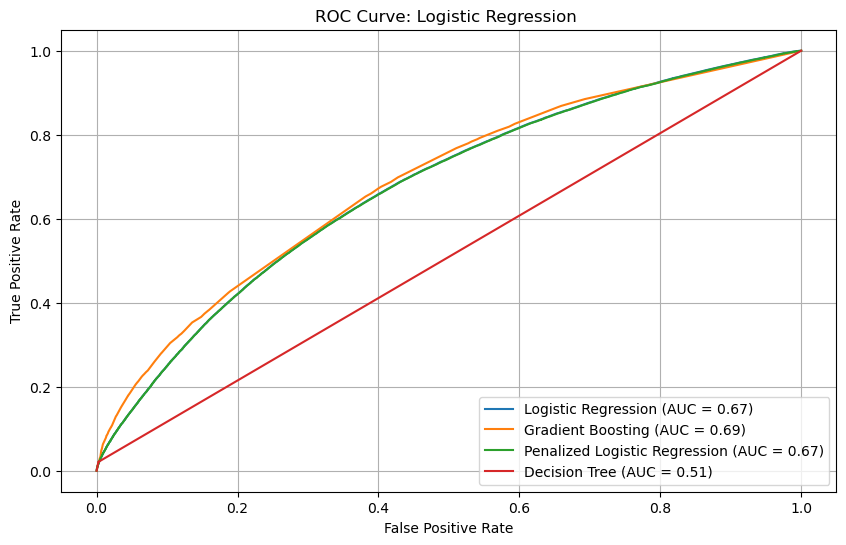

In [43]:
#Define classifiers
classifiers = [
    ('Logistic Regression', PlaneFeatures_pipeLR),
    ('Gradient Boosting', PlaneFeatures_pipegdb),
    ('Penalised Logistic Regression', PlaneFeatures_pipeplr),
    ('Decision Tree', PlaneFeatures_pipetree)
]

#Plot ROC curve
plt.figure(figsize=(10, 6))

for name, classifier in classifiers:
    #Predict probabilities for current classifier
    y_pred = classifier.predict_proba(X_test)[:, 1]
    
    #Compute ROC curve for current classifier
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    
    #Compute AUC score
    auc_score = roc_auc_score(y_test, y_pred)
    
    #Plot ROC curve for current classifier
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name=f'{name} (AUC = {auc_score:.2f})')
    roc_display.plot(ax=plt.gca())

plt.title('ROC Curve: Logistic Regression ')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)

#Print resulting graph
plt.savefig('ROCLR.png')
plt.show()

The ROC curve demonstrates the ability of PlaneFeatures models to predict flight diversions by balancing the correct identification of diverted flights (sensitivity) with the incorrect identification of non-diverted flights (1 - specificity) at different thresholds.

In the logistic regression model, the AUC of 0.674 suggests a moderate capability to differentiate between diverted and non-diverted flights.

In contrast, the Gradient Boosting model achieves a higher AUC value of 0.687, indicating superior discriminatory performance. The Penalized Logistic Regression model also achieves an AUC of 0.674, similar to the Logistic Regression model. However, the Classification Tree model shows less effective performance with an AUC of 0.509.

Overall, this suggests that PlaneFeatures models are effective for predicting flight diversions, with the Gradient Boosting and Logistic Regression models demonstrating notable discriminatory performance.

In [12]:
#Encode categorical features
PlaneFeatures_categoricaltransformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

PlaneFeatures_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', PlaneFeatures_categoricaltransformer, PlaneFeatures_categorical)
    ])

In [13]:
years = [1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004]
#Fit logistic regression model for each year
coefficients = {}
auc_scores = {}

for year, plane_years in zip(years, [yeardata_1995, yeardata_1996, yeardata_1997, yeardata_1998, yeardata_1999, yeardata_2000, yeardata_2001, yeardata_2002, yeardata_2003, yeardata_2004]):
    X_year = plane_years[PlaneFeatures]  
    y_year = plane_years['Diverted']
    
    #Initialise logistic regression model
    LRmodel = LogisticRegression(max_iter=10000)
    
    #Create pipeline
    LogisticRegressionPipeline = Pipeline(steps=[('preprocessor', PlaneFeatures_preprocessor),
                                                 ('classifier', LRmodel)])
    
    #Fit the model
    LogisticRegressionPipeline.fit(X_year, y_year)
    
    #Store coefficients
    coefficients[year] = LogisticRegressionPipeline.named_steps['classifier'].coef_.flatten()
    
    #Predict probabilities
    y_probability = LogisticRegressionPipeline.predict_proba(X_year)[:, 1]
    
    #Compute AUC
    auc_scores[year] = roc_auc_score(y_year, y_probability)


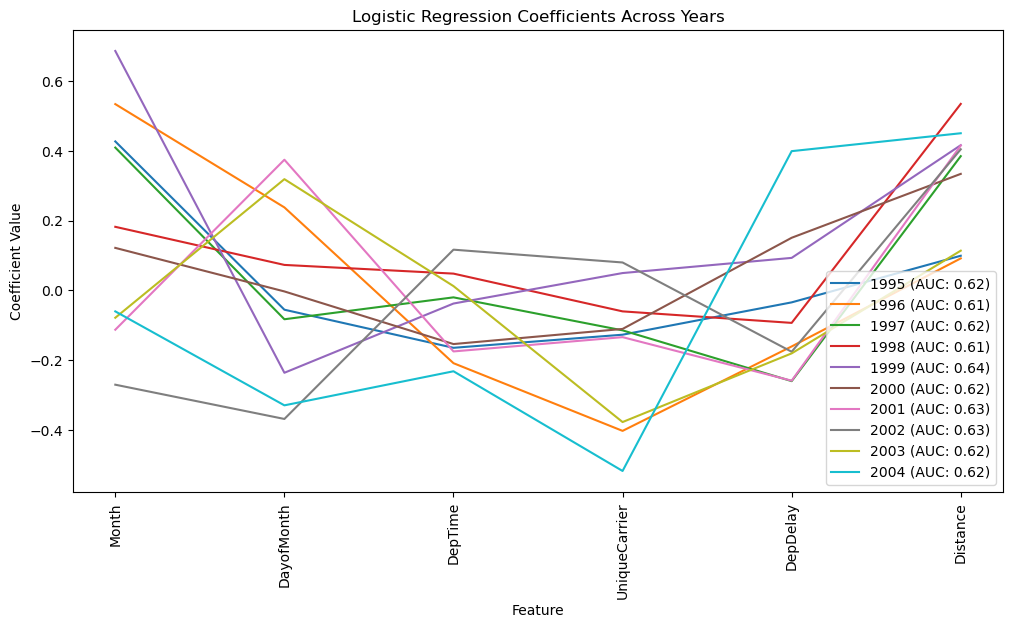

In [14]:
#Plot Logistic Regression model
plt.figure(figsize=(12, 6))

for year, coeffs in coefficients.items():
    #Filter out coefficients corresponding to the original features
    coeffs_original = coeffs[:len(PlaneFeatures)]
    plt.plot(PlaneFeatures, coeffs_original, label=f'{year} (AUC: {auc_scores[year]:.2f})')

plt.xticks(rotation=90)  
plt.xlabel('Feature')
plt.ylabel('Coefficient Value')
plt.title('Logistic Regression Coefficients Across Years')
plt.legend(loc='lower right')

#Print resulting graph
plt.savefig('LRyears.png')
plt.show()


The logistic regression analysis revealed insights into the influence of various attributes on the probability of diverted US flights across different years. Notably, 'UniqueCarriers' exhibited consistently low coefficient values, indicating its minimal impact on flight diversion likelihood, ranging from -0.5 in 2004 to 0.1 in 2002. Conversely, 'Distance' emerged as a significant predictor, consistently yielding high coefficient values, peaking at 0.5 in 1998 and dropping to 0.1 in 1996. This underscores the pivotal role of arrival delays in triggering flight diversions. Furthermore, the feature 'Month' demonstrated fluctuating coefficient values throughout the years, with the highest coefficient of 0.7 observed in 1999 and the lowest of -0.25 in 2002.

In conclusion, the logistic regression analysis underscores the critical role of Distance in influencing flight diversion probabilities, while Carriers ('UniqueCarriers') appears to have minimal impact. Moreover, the fluctuating coefficients of 'Month' suggest varying degrees of influence on flight diversion likelihood across different months. These findings provide valuable insights into the factors driving flight diversions over the years.

#### References

Paramount Business Jets. (n.d.). Is the age of an aircraft a safety factor? [online] Available at: https://www.paramountbusinessjets.com/faq/age-of-aircraft-safety-factor#:~:text=An%20aircraft [Accessed 24 Apr. 2024].